In [46]:
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import pyrtools as pt
from tqdm import tqdm 
from wasserstein.basic_wasserstein import compute_sliced_wass_barycenter
from utils.image_treatment import preprocess_image, image_to_distribution
import matplotlib.pyplot as plt
import pickle
import ot

In [47]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'

In [48]:
image1 = preprocess_image(image_path1, new_size = (75,75))
image2 = preprocess_image(image_path2, new_size = (75,75))
textures = [image1, image2]

In [130]:
def compute_sliced_wass_barycenter(distributions, rho = None, lr = 1e3, k = 200, nb_iter_max = 50, xbinit = None):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    distributions = [x.astype(np.float64) for x in distributions]
    x_torch = [torch.tensor(x).to(device=device) for x in distributions]
    print(distributions[0].dtype)

    if rho is None: 
        n = len(distributions)
        rho = n*[1/n]
    
    if xbinit is None:
        #xbinit = np.random.randn(500, 2) * 10 + 16 #initialization
        xbinit = np.random.normal(0., 1., distributions[0].shape)
    xbary_torch = torch.tensor(xbinit).to(device=device).requires_grad_(True)
    print(xbinit.dtype)


    x_all = np.zeros((nb_iter_max, xbary_torch.shape[0], xbary_torch.shape[1]))

    loss_iter = []

    # generator for random permutations
    gen = torch.Generator(device=device)
    gen.manual_seed(42)


    for i in range(nb_iter_max):

        loss = 0
        for i, x in enumerate(x_torch):
            loss += rho[i] * ot.sliced_wasserstein_distance(xbary_torch, x, n_projections=50, seed=gen)
        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        # performs a step of projected gradient descent
        with torch.no_grad():
            grad = xbary_torch.grad
            xbary_torch -= grad * lr  # / (1 + i / 5e1)  # step
            xbary_torch.grad.zero_()
            x_all[i, :, :] = xbary_torch.clone().detach().cpu().numpy()

    xb = xbary_torch.clone().detach().cpu().numpy()
    return(xb)

### Pyramid

In [135]:
def initialize_random_image(size=(256, 256), channels=3):
    """Initialize a random white noise image f^(0)."""
    return np.random.rand(*size, channels)

In [289]:
def projection(X0, Y):
    """
    X0 : image a projeter 
    Y : ce sur quoi on veut projeter 
    """
    Y_distrib = [Y]
    proj = compute_sliced_wass_barycenter(Y_distrib, rho = None, lr = 1e3, k = 200,  nb_iter_max = 1000, xbinit = X0)
    return(proj)

In [137]:
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [138]:
def from_dict_to_RGB_array(dico):

    output_dict = {}

    # Extract unique filter types by parsing keys
    filters = set(key.split('.')[1] for key in dico.keys())

    # Iterate through each unique filter
    for filter_type in filters:
        # Collect the R, G, B arrays for the current filter
        r_key = f'R.{filter_type}'
        g_key = f'G.{filter_type}'
        b_key = f'B.{filter_type}'
        
        if r_key in dico and g_key in dico and b_key in dico:
            # Stack R, G, B arrays along a new third axis to form a (P, Q, 3) array
            rgb_array = np.stack([dico[r_key], dico[g_key], dico[b_key]], axis=-1)
            
            # Add to output dictionary
            output_dict[filter_type] = rgb_array
    return(output_dict)


# TESTS 
1 - Tester les Y

2 - Tester que la version accélérée renvoie bien les bons résultats 

3 - Tester que les Y_l sont bien corrects avec la fonction qui durent 35 min 

## 1 - Test des Y

In [126]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1/2,1/2], nb_iter_max=1000)
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1/2,1/2], nb_iter_max=1000)
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1/2,1/2], nb_iter_max=1000)
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)

Y_r_1 = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[1, 0], nb_iter_max=1000)
Y_g_1 = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[1, 0], nb_iter_max=1000)
Y_b_1 = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[1, 0], nb_iter_max=1000)
Y_1 = np.stack((Y_r_1, Y_g_1, Y_b_1), axis=-1)

Y_r_0 = compute_sliced_wass_barycenter([x[:,:,0] for x in textures], rho=[0, 1], nb_iter_max=1000)
Y_g_0 = compute_sliced_wass_barycenter([x[:,:,1] for x in textures], rho=[0, 1], nb_iter_max=1000)
Y_b_0 = compute_sliced_wass_barycenter([x[:,:,2] for x in textures], rho=[0, 1], nb_iter_max=1000)
Y_0 = np.stack((Y_r_0, Y_g_0, Y_b_0), axis=-1)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [127]:
Y = np.clip(Y, 0, 255).astype(np.uint8)
Y_1 = np.clip(Y_1, 0, 255).astype(np.uint8)
Y_0 = np.clip(Y_0, 0, 255).astype(np.uint8)


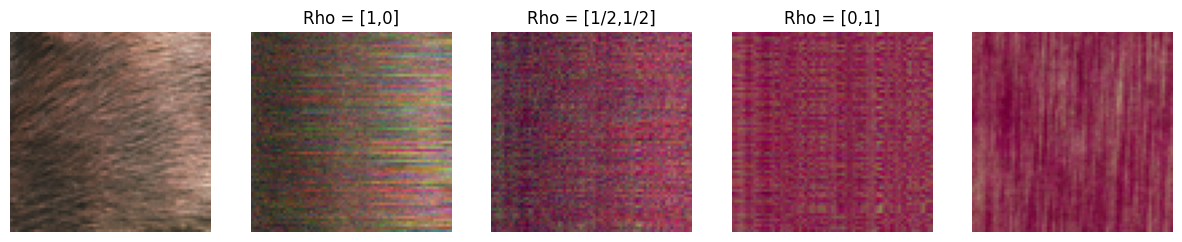

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Affiche image1
plt.subplot(1, 5, 1)
plt.imshow(image1)
plt.axis('off')  # Masquer les axes

# Affiche Y_1 avec le titre
plt.subplot(1, 5, 2)
plt.imshow(Y_1)
plt.title("Rho = [1,0]")
plt.axis('off')

# Affiche Y avec le titre
plt.subplot(1, 5, 3)
plt.imshow(Y)
plt.title("Rho = [1/2,1/2]")
plt.axis('off')

# Affiche Y_0 avec le titre
plt.subplot(1, 5, 4)
plt.imshow(Y_0)
plt.title("Rho = [0,1]")
plt.axis('off')

# Affiche image2
plt.subplot(1, 5, 5)
plt.imshow(image2)
plt.axis('off')

plt.show()


# 2 - Test des Y_l 

Calcul des Y_l 

In [240]:
def compute_steerable_pyramid_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute steerable pyramid coefficients with specified orientations using pyrtools.
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - coeffs: Dictionary of coefficients organized by scale and orientation.
    """
    # Initialize the steerable pyramid
    pyramid = pt.pyramids.SteerablePyramidFreq(image, height=num_scales, order=num_orientations-1)

    return pyramid.pyr_coeffs, pyramid

In [241]:
def compute_3D_wavelets_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute wavelets coefficients (highpass, bandpass, low-residuals) for the 3 channels (R,G,B) of an image
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - wavelets_coeffs: Dictionary of coefficients organized by channel (R,G,B) and then by bandpass (highpass, bandpass -scale and orientation- and low residual).
    """
    wavelets_coeffs = {}
    rgb = ['R','G','B']
    for channel in range(3):
        wavelets_coeffs[rgb[channel]], _ = compute_steerable_pyramid_coeffs(image[:, :, channel], num_scales=num_scales, num_orientations=num_orientations)
    return(wavelets_coeffs)

In [391]:
wavelet_coefs_1 = compute_3D_wavelets_coeffs(image1, num_scales=4, num_orientations=4)
wavelet_coefs_1 = flatten_dict(wavelet_coefs_1)

wavelet_coefs_2 = compute_3D_wavelets_coeffs(image2, num_scales=4, num_orientations=4)
wavelet_coefs_2 = flatten_dict(wavelet_coefs_2)

Y_l =  {}
for key in tqdm(wavelet_coefs_1.keys()): 
    textures = [wavelet_coefs_1[key], wavelet_coefs_2[key]]
    Y_l[key] = compute_sliced_wass_barycenter([x for x in textures], rho=[0, 1], nb_iter_max=1000)
    #Y_l[key] = np.stack((Y_l_r, Y_l_g, Y_l_b), axis=-1)
        

  0%|          | 0/54 [00:00<?, ?it/s]

float64
float64


  2%|▏         | 1/54 [00:03<03:15,  3.68s/it]

float64
float64


  4%|▎         | 2/54 [00:07<03:05,  3.58s/it]

float64
float64


  6%|▌         | 3/54 [00:10<02:57,  3.48s/it]

float64
float64


  7%|▋         | 4/54 [00:13<02:48,  3.38s/it]

float64
float64


  9%|▉         | 5/54 [00:17<02:43,  3.34s/it]

float64
float64


 11%|█         | 6/54 [00:19<02:20,  2.93s/it]

float64
float64


 13%|█▎        | 7/54 [00:21<02:08,  2.73s/it]

float64
float64


 15%|█▍        | 8/54 [00:23<02:00,  2.62s/it]

float64
float64


 17%|█▋        | 9/54 [00:26<01:53,  2.53s/it]

float64
float64


 19%|█▊        | 10/54 [00:27<01:40,  2.28s/it]

float64
float64


 20%|██        | 11/54 [00:29<01:34,  2.21s/it]

float64
float64


 22%|██▏       | 12/54 [00:31<01:25,  2.04s/it]

float64
float64


 24%|██▍       | 13/54 [00:33<01:21,  1.98s/it]

float64
float64


 26%|██▌       | 14/54 [00:34<01:11,  1.78s/it]

float64
float64


 28%|██▊       | 15/54 [00:36<01:03,  1.62s/it]

float64
float64


 30%|██▉       | 16/54 [00:37<00:58,  1.53s/it]

float64
float64


 31%|███▏      | 17/54 [00:38<00:53,  1.46s/it]

float64
float64


 33%|███▎      | 18/54 [00:39<00:50,  1.41s/it]

float64
float64


 35%|███▌      | 19/54 [00:43<01:07,  1.93s/it]

float64
float64


 37%|███▋      | 20/54 [00:46<01:16,  2.26s/it]

float64
float64


 39%|███▉      | 21/54 [00:49<01:23,  2.52s/it]

float64
float64


 41%|████      | 22/54 [00:52<01:28,  2.77s/it]

float64
float64


 43%|████▎     | 23/54 [00:56<01:37,  3.13s/it]

float64
float64


 44%|████▍     | 24/54 [00:59<01:27,  2.93s/it]

float64
float64


 46%|████▋     | 25/54 [01:01<01:20,  2.79s/it]

float64
float64


 48%|████▊     | 26/54 [01:04<01:16,  2.73s/it]

float64
float64


 50%|█████     | 27/54 [01:06<01:13,  2.71s/it]

float64
float64


 52%|█████▏    | 28/54 [01:08<01:03,  2.43s/it]

float64
float64


 54%|█████▎    | 29/54 [01:10<00:54,  2.17s/it]

float64
float64


 56%|█████▌    | 30/54 [01:11<00:47,  1.96s/it]

float64
float64


 57%|█████▋    | 31/54 [01:13<00:42,  1.83s/it]

float64
float64


 59%|█████▉    | 32/54 [01:14<00:36,  1.65s/it]

float64
float64


 61%|██████    | 33/54 [01:15<00:32,  1.56s/it]

float64
float64


 63%|██████▎   | 34/54 [01:16<00:29,  1.47s/it]

float64
float64


 65%|██████▍   | 35/54 [01:18<00:26,  1.42s/it]

float64
float64


 67%|██████▋   | 36/54 [01:19<00:24,  1.36s/it]

float64
float64


 69%|██████▊   | 37/54 [01:22<00:32,  1.90s/it]

float64
float64


 70%|███████   | 38/54 [01:25<00:36,  2.27s/it]

float64
float64


 72%|███████▏  | 39/54 [01:28<00:37,  2.52s/it]

float64
float64


 74%|███████▍  | 40/54 [01:32<00:38,  2.72s/it]

float64
float64


 76%|███████▌  | 41/54 [01:35<00:36,  2.85s/it]

float64
float64


 78%|███████▊  | 42/54 [01:37<00:31,  2.64s/it]

float64
float64


 80%|███████▉  | 43/54 [01:39<00:27,  2.52s/it]

float64
float64


 81%|████████▏ | 44/54 [01:41<00:24,  2.41s/it]

float64
float64


 83%|████████▎ | 45/54 [01:43<00:21,  2.34s/it]

float64
float64


 85%|████████▌ | 46/54 [01:45<00:17,  2.18s/it]

float64
float64


 87%|████████▋ | 47/54 [01:47<00:14,  2.08s/it]

float64
float64


 89%|████████▉ | 48/54 [01:49<00:11,  2.00s/it]

float64
float64


 91%|█████████ | 49/54 [01:51<00:09,  1.95s/it]

float64
float64


 93%|█████████▎| 50/54 [01:52<00:07,  1.77s/it]

float64
float64


 94%|█████████▍| 51/54 [01:53<00:04,  1.66s/it]

float64
float64


 96%|█████████▋| 52/54 [01:55<00:03,  1.58s/it]

float64
float64


 98%|█████████▊| 53/54 [01:56<00:01,  1.55s/it]

float64
float64


100%|██████████| 54/54 [01:58<00:00,  2.19s/it]


In [396]:
Y_save = Y_l

In [397]:
Y_l

{'R.residual_highpass': array([[-5.73811648, -1.40156018, -1.34321345, ...,  0.74483373,
         -1.86100759,  6.16125895],
        [-5.50930569,  1.04462604,  0.73610079, ...,  3.3472071 ,
         -0.91985128,  5.72901076],
        [ 4.74261178, -1.14762769,  1.27995255, ..., -0.55673648,
          6.72285098, -3.02717782],
        ...,
        [-0.05070538,  5.03095661, -1.48038887, ..., -3.18362293,
          5.3922522 , -1.77007277],
        [-3.50689279,  7.8160634 ,  0.90864804, ...,  8.05801146,
          3.74973147,  5.32885203],
        [ 2.68777826, -0.77625715, -2.08965549, ...,  0.91104665,
          0.97432521, -2.58093028]]),
 'R.(0, 0)': array([[-5.06565161,  3.27343338,  2.02400202, ..., -1.32193467,
          4.22465092, -1.04434877],
        [-1.37676448,  1.90391229,  0.9346481 , ...,  2.58918199,
         -1.83520361, -3.33449176],
        [-6.06706271,  4.38690623,  1.33985985, ...,  0.40882034,
          7.18046957, -3.76874538],
        ...,
        [-5.0660410

In [215]:
Y_l = from_dict_to_RGB_array(Y_l)

In [400]:
f_0 = initialize_random_image(size=(75, 75), channels=3)
f_0_pyr = compute_3D_wavelets_coeffs(f_0, num_scales=4, num_orientations=4)
f_0_pyr = flatten_dict(f_0_pyr)
#f_0_pyr = from_dict_to_RGB_array(f_0_pyr)
# Y_l = flatten_dict(Y_l)
# Y_l = from_dict_to_RGB_array(Y_l)

In [211]:
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [401]:
c_l_n = {}
for key in tqdm(Y_l.keys()):        
    # c_l_n_r = projection(f_0_pyr[key][:,:,0], Y_l[key][:,:,0])
    # c_l_n_g = projection(f_0_pyr[key][:,:,1], Y_l[key][:,:,1])
    # c_l_n_b = projection(f_0_pyr[key][:,:,2], Y_l[key][:,:,2])
    c_l_n[key] = projection(f_0_pyr[key], Y_l[key])

  0%|          | 0/54 [00:00<?, ?it/s]

float64
float64


  2%|▏         | 1/54 [00:02<01:55,  2.19s/it]

float64
float64


  4%|▎         | 2/54 [00:04<01:47,  2.06s/it]

float64
float64


  6%|▌         | 3/54 [00:06<01:43,  2.03s/it]

float64
float64


  7%|▋         | 4/54 [00:08<01:40,  2.02s/it]

float64
float64


  9%|▉         | 5/54 [00:10<01:36,  1.98s/it]

float64
float64


 11%|█         | 6/54 [00:11<01:23,  1.74s/it]

float64
float64


 13%|█▎        | 7/54 [00:12<01:17,  1.65s/it]

float64
float64


 15%|█▍        | 8/54 [00:14<01:10,  1.53s/it]

float64
float64


 17%|█▋        | 9/54 [00:15<01:07,  1.50s/it]

float64
float64


 19%|█▊        | 10/54 [00:16<00:57,  1.30s/it]

float64
float64


 20%|██        | 11/54 [00:17<00:49,  1.16s/it]

float64
float64


 22%|██▏       | 12/54 [00:17<00:43,  1.05s/it]

float64
float64


 24%|██▍       | 13/54 [00:18<00:39,  1.04it/s]

float64
float64


 26%|██▌       | 14/54 [00:19<00:35,  1.14it/s]

float64
float64


 28%|██▊       | 15/54 [00:20<00:31,  1.23it/s]

float64
float64


 30%|██▉       | 16/54 [00:20<00:29,  1.29it/s]

float64
float64


 31%|███▏      | 17/54 [00:21<00:27,  1.34it/s]

float64
float64


 33%|███▎      | 18/54 [00:22<00:25,  1.40it/s]

float64
float64


 35%|███▌      | 19/54 [00:23<00:35,  1.01s/it]

float64
float64


 37%|███▋      | 20/54 [00:25<00:40,  1.20s/it]

float64
float64


 39%|███▉      | 21/54 [00:27<00:43,  1.33s/it]

float64
float64


 41%|████      | 22/54 [00:28<00:45,  1.44s/it]

float64
float64


 43%|████▎     | 23/54 [00:30<00:46,  1.48s/it]

float64
float64


 44%|████▍     | 24/54 [00:31<00:40,  1.36s/it]

float64
float64


 46%|████▋     | 25/54 [00:32<00:40,  1.39s/it]

float64
float64


 48%|████▊     | 26/54 [00:34<00:37,  1.33s/it]

float64
float64


 50%|█████     | 27/54 [00:35<00:33,  1.25s/it]

float64
float64


 52%|█████▏    | 28/54 [00:36<00:30,  1.16s/it]

float64
float64


 54%|█████▎    | 29/54 [00:36<00:26,  1.07s/it]

float64
float64


 56%|█████▌    | 30/54 [00:37<00:24,  1.01s/it]

float64
float64


 57%|█████▋    | 31/54 [00:38<00:21,  1.06it/s]

float64
float64


 59%|█████▉    | 32/54 [00:39<00:18,  1.16it/s]

float64
float64


 61%|██████    | 33/54 [00:39<00:17,  1.22it/s]

float64
float64


 63%|██████▎   | 34/54 [00:40<00:16,  1.21it/s]

float64
float64


 65%|██████▍   | 35/54 [00:41<00:15,  1.26it/s]

float64
float64


 67%|██████▋   | 36/54 [00:42<00:13,  1.29it/s]

float64
float64


 69%|██████▊   | 37/54 [00:43<00:17,  1.05s/it]

float64
float64


 70%|███████   | 38/54 [00:46<00:21,  1.34s/it]

float64
float64


 72%|███████▏  | 39/54 [00:47<00:22,  1.51s/it]

float64
float64


 74%|███████▍  | 40/54 [00:50<00:24,  1.74s/it]

float64
float64


 76%|███████▌  | 41/54 [00:51<00:22,  1.74s/it]

float64
float64


 78%|███████▊  | 42/54 [00:53<00:19,  1.59s/it]

float64
float64


 80%|███████▉  | 43/54 [00:54<00:15,  1.45s/it]

float64
float64


 81%|████████▏ | 44/54 [00:55<00:13,  1.35s/it]

float64
float64


 83%|████████▎ | 45/54 [00:56<00:11,  1.27s/it]

float64
float64


 85%|████████▌ | 46/54 [00:57<00:09,  1.15s/it]

float64
float64


 87%|████████▋ | 47/54 [00:58<00:07,  1.04s/it]

float64
float64


 89%|████████▉ | 48/54 [00:58<00:05,  1.04it/s]

float64
float64


 91%|█████████ | 49/54 [00:59<00:04,  1.10it/s]

float64
float64


 93%|█████████▎| 50/54 [01:00<00:03,  1.19it/s]

float64
float64


 94%|█████████▍| 51/54 [01:01<00:02,  1.20it/s]

float64
float64


 96%|█████████▋| 52/54 [01:01<00:01,  1.26it/s]

float64
float64


 98%|█████████▊| 53/54 [01:02<00:00,  1.31it/s]

float64
float64


100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


In [402]:
c_l_n_save = c_l_n

In [404]:
coef, pyr = compute_steerable_pyramid_coeffs(image1[:,:,1], num_scales=4, num_orientations=4)

In [405]:
coef.keys()
pyr.pyr_coeffs[(0, 0)].shape

(75, 75)

In [313]:
import ast

def from_str_to_tuple_dict(data_dict):

    # New dictionary to hold the modified keys
    modified_dict = {}

    # Iterate over the original dictionary
    for key, value in data_dict.items():
        # Try to convert keys that look like tuples into actual tuple types
        try:
            # Use ast.literal_eval to safely evaluate keys that are tuples as strings
            evaluated_key = ast.literal_eval(key)
            if isinstance(evaluated_key, tuple):
                modified_dict[evaluated_key] = value
            else:
                modified_dict[key] = value
        except (ValueError, SyntaxError):
            # If the key isn't a tuple-like string, keep it as-is
            modified_dict[key] = value
    return(modified_dict)

In [409]:
# c_l_n = from_str_to_tuple_dict(c_l_n)

In [413]:
c_l_n

{'R.residual_highpass': array([[-0.46389991, -1.04717683,  1.34976821, ...,  2.22629709,
         -2.98411523, -4.30821432],
        [-5.20148075,  6.36036604, -3.7013234 , ...,  5.88989372,
         -1.57830158,  7.83580237],
        [ 2.96711468, -2.09993735, -3.81181884, ..., -1.4293722 ,
         -1.83370527, -1.00119562],
        ...,
        [-9.71240479,  2.09790846,  1.23867379, ..., -2.19270507,
         -7.69236428,  5.94969174],
        [-2.16038676,  6.27666481, -4.79370212, ...,  0.55003776,
         -2.59339427,  3.63683958],
        [-2.47330316, -0.93945152, -3.445809  , ...,  0.08673904,
         -0.98245623,  0.11886533]]),
 'R.(0, 0)': array([[-3.30278105,  2.18525831,  2.31559114, ..., -5.41705222,
          6.53856988, -2.39650669],
        [ 4.52337234, -2.49254744,  0.98377009, ..., -1.19707883,
         -9.51524816,  0.33712228],
        [ 3.33494109, -1.21317137,  2.71362455, ...,  0.33864365,
         -8.59681886,  0.06254533],
        ...,
        [ 1.3615782

In [423]:
c_l_n['R.(0, 0)'][0]
pyr.pyr_coeffs.keys()
c_l_n.keys()

dict_keys(['R.residual_highpass', 'R.(0, 0)', 'R.(0, 1)', 'R.(0, 2)', 'R.(0, 3)', 'R.(1, 0)', 'R.(1, 1)', 'R.(1, 2)', 'R.(1, 3)', 'R.(2, 0)', 'R.(2, 1)', 'R.(2, 2)', 'R.(2, 3)', 'R.(3, 0)', 'R.(3, 1)', 'R.(3, 2)', 'R.(3, 3)', 'R.residual_lowpass', 'G.residual_highpass', 'G.(0, 0)', 'G.(0, 1)', 'G.(0, 2)', 'G.(0, 3)', 'G.(1, 0)', 'G.(1, 1)', 'G.(1, 2)', 'G.(1, 3)', 'G.(2, 0)', 'G.(2, 1)', 'G.(2, 2)', 'G.(2, 3)', 'G.(3, 0)', 'G.(3, 1)', 'G.(3, 2)', 'G.(3, 3)', 'G.residual_lowpass', 'B.residual_highpass', 'B.(0, 0)', 'B.(0, 1)', 'B.(0, 2)', 'B.(0, 3)', 'B.(1, 0)', 'B.(1, 1)', 'B.(1, 2)', 'B.(1, 3)', 'B.(2, 0)', 'B.(2, 1)', 'B.(2, 2)', 'B.(2, 3)', 'B.(3, 0)', 'B.(3, 1)', 'B.(3, 2)', 'B.(3, 3)', 'B.residual_lowpass'])

In [498]:
L = []
for key in pyr.pyr_coeffs.keys():
    print((c_l_n['R.'+str(key)]* pyr.pyr_coeffs[key]).shape)

(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(19, 19)
(19, 19)
(19, 19)
(19, 19)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(5, 5)


In [451]:

#reconstructed_image = {}

# reconstructed_r = np.sum([c_l_n['R.'+str(key)] * pyr.pyr_coeffs[key] for key in pyr.pyr_coeffs.keys()], axis=0)
# reconstructed_g = np.sum([c_l_n['G.'+str(key)] * pyr.pyr_coeffs[key] for key in pyr.pyr_coeffs.keys()], axis=0)
# reconstructed_b = np.sum([c_l_n['B.'+str(key)] * pyr.pyr_coeffs[key] for key in pyr.pyr_coeffs.keys()], axis=0)

#reconstructed_image[key] = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=-1)
from scipy.ndimage import zoom

def resize_to_target(coef, target_shape):
    """
    Redimensionne les coefficients pour correspondre à la taille cible en utilisant scipy.ndimage.zoom.
    """
    # Calcul du facteur d'échelle pour chaque dimension
    zoom_factors = (target_shape[0] / coef.shape[0], target_shape[1] / coef.shape[1])
    # Redimensionne avec le facteur d'échelle
    return zoom(coef, zoom_factors, order=1)

In [474]:
Y_l_r = {}
Y_l_g = {}
Y_l_b = {}

# Séparer les clés en supprimant le préfixe et en gérant les résidus
for key, value in Y_l.items():
    # Extraire le préfixe et le reste
    prefix, rest = key.split('.', 1)
    
    # Si rest contient des indices, les convertir en tuple, sinon conserver le type de résidu
    if rest.startswith('(') and rest.endswith(')'):
        indices = tuple(map(int, rest.strip('()').split(', ')))  # Convertir en tuple d'entiers
    else:
        indices = rest  # Garde "residual_highpass" ou "residual_lowpass" comme chaîne

    # Ajouter aux dictionnaires en fonction du préfixe
    if prefix == 'R':
        Y_l_r[indices] = value
    elif prefix == 'G':
        Y_l_g[indices] = value
    elif prefix == 'B':
        Y_l_b[indices] = value

# Résultat
print("Y_l_r:", Y_l_r)
print("Y_l_g:", Y_l_g)
print("Y_l_b:", Y_l_b)

Y_l_r: {'residual_highpass': array([[-5.73811648, -1.40156018, -1.34321345, ...,  0.74483373,
        -1.86100759,  6.16125895],
       [-5.50930569,  1.04462604,  0.73610079, ...,  3.3472071 ,
        -0.91985128,  5.72901076],
       [ 4.74261178, -1.14762769,  1.27995255, ..., -0.55673648,
         6.72285098, -3.02717782],
       ...,
       [-0.05070538,  5.03095661, -1.48038887, ..., -3.18362293,
         5.3922522 , -1.77007277],
       [-3.50689279,  7.8160634 ,  0.90864804, ...,  8.05801146,
         3.74973147,  5.32885203],
       [ 2.68777826, -0.77625715, -2.08965549, ...,  0.91104665,
         0.97432521, -2.58093028]]), (0, 0): array([[-5.06565161,  3.27343338,  2.02400202, ..., -1.32193467,
         4.22465092, -1.04434877],
       [-1.37676448,  1.90391229,  0.9346481 , ...,  2.58918199,
        -1.83520361, -3.33449176],
       [-6.06706271,  4.38690623,  1.33985985, ...,  0.40882034,
         7.18046957, -3.76874538],
       ...,
       [-5.06604109,  2.17934372,  1.

In [483]:
size = 75
noise = np.random.randn(size, size)
noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise, height=4, order=3)

noisy_pyr.pyr_coeffs = Y_l_r
reconstructed_pyr_r = noisy_pyr.recon_pyr()
noisy_pyr.pyr_coeffs = Y_l_g
reconstructed_pyr_g = noisy_pyr.recon_pyr()
noisy_pyr.pyr_coeffs = Y_l_b
reconstructed_pyr_b = noisy_pyr.recon_pyr()

reconstructed_pyr = np.stack([reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b])

In [489]:
f_k_1 = projection(reconstructed_pyr.reshape(-1,3), Y.reshape(-1,3)).reshape((75,75,3))

float64
float64


In [496]:
np.clip(f_k_1, 0, 255).astype(np.uint8)

(75, 75, 3)

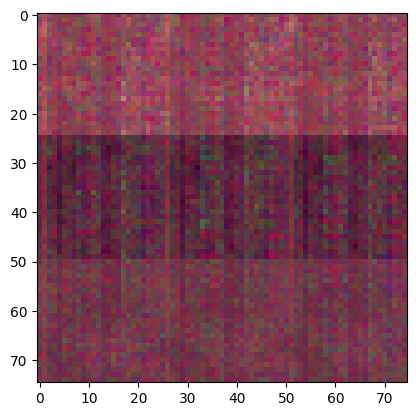

In [497]:
plt.imshow(np.clip(f_k_1, 0, 255).astype(np.uint8))
#plt.imshow(reconstructed_pyr)